In [1]:
#I'm just going to jump right in for now and run my imports
import math 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#I want to have clean outputs so I'll go ahead and do this here as well.
import warnings
warnings.filterwarnings('ignore')

In [2]:
#And now to load in my data (I already exported this as my training and testing data, so this should be fast).
X_tr = pd.read_csv('X_train.csv')
X_te = pd.read_csv('X_test.csv')

y_tr = pd.read_csv('y_train.csv')
y_te = pd.read_csv('y_test.csv')

In [3]:
#I just want to make sure that everything went smoothly, so I'll just peek at the data
X_tr.head(1)

,song_duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,audio_valence,...,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11
0,-0.867944,-0.92484,0.068885,1.463252,-0.388402,-0.930734,0.653316,-0.130142,0.98935,1.175261,...,0,0,0,0,0,0,0,1,0,0


In [4]:
X_te.head(1)

,song_duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,audio_valence,...,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11
0,0.690136,0.923233,0.504953,-0.024704,-0.391987,-0.381865,0.304084,-0.720227,-0.632693,-0.264326,...,0,0,0,0,0,0,0,1,0,0


In [5]:
y_tr.head(1)

,song_popularity
0,0


In [6]:
y_te.head(1)

,song_popularity
0,66


Everything looks okay, so now it is time to do what I came here for, modeling. For one, I am going to use Grid Search for hyperparameter optimization, as while I know it is not necessarily the best in terms of time efficentcy it should get me better results, which I think will be necessary as this dataset was shown in the EDA to have very loose corelations and I hope this will help in counteracting that. As for the models that I am going to test, I think I'll try out 5 and see how well they work. Well, here is to hoping to find the best model!

In [20]:
#Run the sklearn imports!
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

In [12]:
#I'm going to start with the logistic regression model
lr_model = LinearRegression()
lr_params = {'fit_intercept' : [True, False],
             'normalize'     : [True, False],
             'positive'      : [True, False]
            }
#I think for all of these I will just go for the basic 5-fold cross validation as I think it works well.
lr_grid = GridSearchCV(estimator = lr_model, param_grid = lr_params, n_jobs = -1)
lr_grid.fit(X_tr, y_tr)

GridSearchCV(estimator=LinearRegression(), n_jobs=-1,
             param_grid={'fit_intercept': [True, False],
                         'normalize': [True, False],
                         'positive': [True, False]})

In [16]:
print('Best Params:', lr_grid.best_estimator_)
lr_train_r2_best = lr_grid.best_score_
print('Best Score:', lr_train_r2_best)
lr_test_r2 = lr_grid.score(X_te, y_te)
print('On Test Data R^2:', lr_test_r2)

Best Params: LinearRegression(normalize=True)
Best Score: 0.017998560767283966
On Test Data R^2: 0.01879229369607338


In [17]:
#The other metric I will use to judge my models will be MAE, as I am not trying to define a loss function and I want to 
#choose something that will be more robust to outliers.
from sklearn.metrics import mean_absolute_error
lr_y_pred = lr_grid.predict(X_te)
lr_MAE = mean_absolute_error(y_te, lr_y_pred)
print('Mean Absolute Error:', lr_MAE)

Mean Absolute Error: 15.828011479907058


In [18]:
#So, not so great so far, but we are just starting. Lets move on to the KNeighbor regressor!
knn_model = KNeighborsRegressor()
#I am just doing 2^i + 1 for my neighbor amounts as it will always get me a odd number and will test out numbers on an
#exponential curve.
knn_params = {'n_neighbors' : [3, 5, 9, 17, 33, 65, 129, 257, 513],
              'weights'     : ['uniform', 'distance'],
              'algorithm'   : ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p'           : [1, 2]
             }
knn_grid = GridSearchCV(estimator = knn_model, param_grid = knn_params, n_jobs = -1)
knn_grid.fit(X_tr, y_tr)

GridSearchCV(estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [3, 5, 9, 17, 33, 65, 129, 257, 513],
                         'p': [1, 2], 'weights': ['uniform', 'distance']})

In [19]:
print('Best Params:', knn_grid.best_estimator_)
knn_train_r2_best = knn_grid.best_score_
print('Best Score:', knn_train_r2_best)
knn_test_r2 = knn_grid.score(X_te, y_te)
print('On Test Data R^2:', knn_test_r2)

knn_y_pred = knn_grid.predict(X_te)
knn_MAE = mean_absolute_error(y_te, knn_y_pred)
print('Mean Absolute Error:', knn_MAE)

Best Params: KNeighborsRegressor(algorithm='ball_tree', n_neighbors=129, p=1)
Best Score: 0.03616738187708275
On Test Data R^2: 0.04461926458390941
Mean Absolute Error: 15.419288017596687


In [21]:
#Improvement! Not necessarily something I would put money on but improvement none the less!
#Next I'm going to move into using my ensemble models, starting with a random forest model.
RF_model = RandomForestRegressor()
#I could try out more parameters, but for the sake of time I think these should be enough.
RF_params = {'n_estimators'      : [10, 25, 50, 100, 250, 500],
             'max_features'      : ['auto', 'sqrt', 'log2'],
             'bootstrap'         : [True, False],
             'min_samples_split' : [2, 4, 8, 10]
            }
RF_grid = GridSearchCV(estimator = RF_model, param_grid = RF_params, n_jobs = -1)
RF_grid.fit(X_tr, y_tr)

GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_split': [2, 4, 8, 10],
                         'n_estimators': [10, 25, 50, 100, 250, 500]})

In [22]:
print('Best Params:', RF_grid.best_estimator_)
RF_train_r2_best = RF_grid.best_score_
print('Best Score:', RF_train_r2_best)
RF_test_r2 = RF_grid.score(X_te, y_te)
print('On Test Data R^2:', RF_test_r2)

RF_y_pred = RF_grid.predict(X_te)
RF_MAE = mean_absolute_error(y_te, RF_y_pred)
print('Mean Absolute Error:', RF_MAE)

Best Params: RandomForestRegressor(max_features='sqrt', min_samples_split=10,
                      n_estimators=500)
Best Score: 0.056225512472251694
On Test Data R^2: 0.05760070878494461
Mean Absolute Error: 15.567252257144762


In [23]:
#Okay, so based off this result it looks like I could get some better results if I were to increase the min_samples_split 
#and the number of estimators, but doing this was already pretty computationally expensive and time consuming and even then
#it's still very similar to the KNN model from earlier with a slightly better R^2 score and a slightly worse mean absolute
#error, so I'll keep in mind if at the end this is the number 2 model that I should go back and try some more variables, but
#for now I am going to try an AdaBoost model and hope for better results!
ada_model = AdaBoostRegressor()
#While this might also only run decision trees, it should still give different results than the RF model from before.
ada_params = {'loss'          : ['linear', 'square', 'exponential'], 
              'n_estimators'  : [10, 25, 50, 100, 250, 500],
              'learning_rate' : [0.001, 0.01, 0.1, 1.0]
             }
ada_grid = GridSearchCV(estimator = ada_model, param_grid = ada_params, n_jobs = -1)
ada_grid.fit(X_tr, y_tr)

GridSearchCV(estimator=AdaBoostRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 1.0],
                         'loss': ['linear', 'square', 'exponential'],
                         'n_estimators': [10, 25, 50, 100, 250, 500]})

In [24]:
print('Best Params:', ada_grid.best_estimator_)
ada_train_r2_best = ada_grid.best_score_
print('Best Score:', ada_train_r2_best)
ada_test_r2 = ada_grid.score(X_te, y_te)
print('On Test Data R^2:', ada_test_r2)

ada_y_pred = ada_grid.predict(X_te)
ada_MAE = mean_absolute_error(y_te, ada_y_pred)
print('Mean Absolute Error:', ada_MAE)

Best Params: AdaBoostRegressor(learning_rate=0.01)
Best Score: 0.03996600822022689
On Test Data R^2: 0.03170474627008146
Mean Absolute Error: 15.872577282004633


In [25]:
#Okay, so it looks like it didn't perform better (in fact in some ways it performed worse than the linear regession model), 
#and even then I am not to sure if I'm feeling comfortable enough to deny the null hypothesis that you can't meaningfully
#predict the popularity of a song based off the song elements. That said, I still have one model I want to try before I call
#it quits for the model testing before the direct comparison and (potential) changing of the random forest model. So I 
#suppose now's the time for neural network!
mlp_model = MLPRegressor()
mlp_params = {'solver'     : ['lbfgs', 'sgd', 'adam'],
              'activation' : ['identity', 'logistic', 'tanh', 'relu'],
              'alpha'      : [0.00001, 0.0001, 0.001, 0.01]
             }
mlp_grid = GridSearchCV(estimator = ada_model, param_grid = ada_params, n_jobs = -1)
mlp_grid.fit(X_tr, y_tr)

GridSearchCV(estimator=AdaBoostRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 1.0],
                         'loss': ['linear', 'square', 'exponential'],
                         'n_estimators': [10, 25, 50, 100, 250, 500]})

In [26]:
print('Best Params:', mlp_grid.best_estimator_)
mlp_train_r2_best = mlp_grid.best_score_
print('Best Score:', mlp_train_r2_best)
mlp_test_r2 = mlp_grid.score(X_te, y_te)
print('On Test Data R^2:', mlp_test_r2)

mlp_y_pred = mlp_grid.predict(X_te)
mlp_MAE = mean_absolute_error(y_te, mlp_y_pred)
print('Mean Absolute Error:', mlp_MAE)

Best Params: AdaBoostRegressor(learning_rate=0.001, loss='square', n_estimators=25)
Best Score: 0.03975048751403916
On Test Data R^2: 0.031961549574077486
Mean Absolute Error: 15.788771215507797


Well, looking at it the results are not necessarily the best and I'm sure there are ways in changing the tried hyperparameters in such a way where I could get better results, but the only model that I feel could warrent a change would be the random forest model, and if I did try to do that it would be even more time consuming and would still have the chance of not much improvment, so I will just move forward with the cross examination of the models and figure out which one is the best.

In [33]:
#Okay, for a better look at the results, its time to put everything into a dataframe.
dict_for_e = {'model'                      : ['Linear Regression', 'KNN Regression', 'Random Forest Regression', 'AdaBoost Regression', 'Multi-Layer Perceptron Regression'],
              'average r2 cross val score' : [lr_train_r2_best, knn_train_r2_best, RF_train_r2_best, ada_train_r2_best, mlp_train_r2_best],
              'test r2 score'              : [lr_test_r2, knn_test_r2, RF_test_r2, ada_test_r2, mlp_test_r2],
              'mean absolute error'        : [lr_MAE, knn_MAE, RF_MAE, ada_MAE, mlp_MAE]
             }
comp_df = pd.DataFrame(dict_for_e)
#I only have 5 categories so head is really useful here!
comp_df.head()

,model,average r2 cross val score,test r2 score,mean absolute error
0,Linear Regression,0.017999,0.018792,15.828011
1,KNN Regression,0.036167,0.044619,15.419288
2,Random Forest Regression,0.056226,0.057601,15.567252
3,AdaBoost Regression,0.039966,0.031705,15.872577
4,Multi-Layer Perceptron Regression,0.039750,0.031962,15.788771


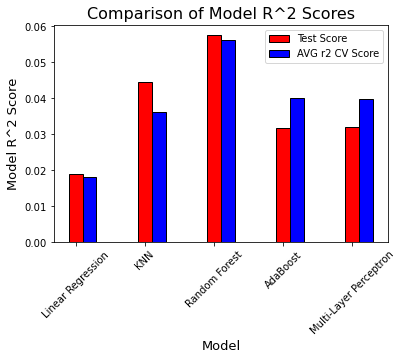

In [42]:
#The main metric that I am going off of for analysis is the MAE score, and going off of that I would have to say that the
#KNN model is the best. Lets just vizualize these results in a slightly different way. I'll start with plotting the r2 
#scores and then move on to the main metric of the mean absolute error.
ind_1 = [1, 2, 3, 4, 5]
ind_2 = [1.2, 2.2, 3.2, 4.2, 5.2]
labels = ['Linear Regression', 'KNN', 'Random Forest', 'AdaBoost', 'Multi-Layer Perceptron']

_ = plt.bar(ind_1, comp_df['test r2 score'], color = 'red', label = 'Test Score', width = 0.2, edgecolor = 'black')
_ = plt.bar(ind_2, comp_df['average r2 cross val score'], color = 'blue', label = 'AVG r2 CV Score', width = 0.2, edgecolor = 'black')
_ = plt.xlabel('Model', fontsize = 13)
_ = plt.ylabel('Model R^2 Score', fontsize = 13)
_ = plt.xticks(ticks = ind_1, labels = labels, rotation = 45)
_ = plt.legend()
_ = plt.title('Comparison of Model R^2 Scores', fontsize = 16)
_ = plt.savefig('r2comp.png')
plt.show()

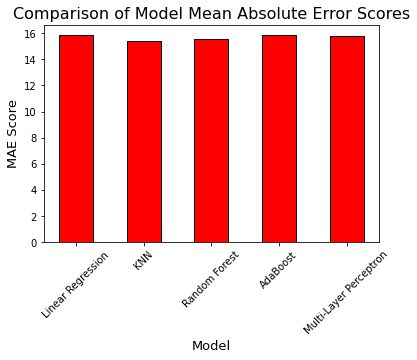

In [45]:
_ = plt.bar(ind_1, comp_df['mean absolute error'], color = 'red', label = 'Mean Absolute Error', width = 0.5, edgecolor = 'black')
_ = plt.xlabel('Model', fontsize = 13)
_ = plt.ylabel('MAE Score', fontsize = 13)
_ = plt.xticks(ticks = ind_1, labels = labels, rotation = 45)
_ = plt.title('Comparison of Model Mean Absolute Error Scores', fontsize = 16)
_ = plt.savefig('maecomp.png')
plt.show()

By the looks of it, things could be better. It seems like none of the models are working that well at describing a songs popularity. The last thing that I am going to check is trying out some different hyperparameters in the random forest model as most of the models have a MAE scores so close that making a decision on the model off that metric could be difficult to justify. Additionally, with such low r2 scores it seems difficult to justify saying there is much of an impact on a songs popularity based off the features as they stand. This could possibly be changed by doing additional feature engineering, but I would think any change would still only mildly increase the usability of a model for predicting the popularity of a song. At this point, the main thing I would feel comfortable saying is that song popularity is barely correlative with the musical elements of the song and that it has more to do with other, non modeled factors. Furthermore, this would support the null hypothesis that a songs popularity is not related to its musical properties. That being said I just want to try one more time to get a model that could better describe the data, and going off the previous two graphs I think the potential improvement could only really come from the random forest model. This will (of course) come with an increase in fitting time, but I think that is an okay price to pay if it can get me better results.

In [46]:
RF_params2 = {'n_estimators'      : [500, 750, 1000],#500 was best so will increase range values (this will take longer)
             'max_features'      : ['sqrt'],#shown best from earlier
             'bootstrap'         : [True, False],#did not specify so will keep as is
             'min_samples_split' : [10, 15, 20, 25, 30]#best was 10 earlier, so will increase range values
            }
RF_grid2 = GridSearchCV(estimator = RF_model, param_grid = RF_params2, n_jobs = -1)
RF_grid2.fit(X_tr, y_tr)

GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_features': ['sqrt'],
                         'min_samples_split': [10, 15, 20, 25, 30],
                         'n_estimators': [500, 750, 1000]})

In [47]:
print('Best Params:', RF_grid2.best_estimator_)
RF2_train_r2_best = RF_grid2.best_score_
print('Best Score:', RF2_train_r2_best)
RF2_test_r2 = RF_grid2.score(X_te, y_te)
print('On Test Data R^2:', RF2_test_r2)

RF2_y_pred = RF_grid2.predict(X_te)
RF2_MAE = mean_absolute_error(y_te, RF2_y_pred)
print('Mean Absolute Error:', RF2_MAE)

Best Params: RandomForestRegressor(max_features='sqrt', min_samples_split=30,
                      n_estimators=750)
Best Score: 0.05790954115139431
On Test Data R^2: 0.054782981582145784
Mean Absolute Error: 15.57042189593364


Well, that actually produced worse results. I suppose there may be something to say in reguards to my increase of values at random to be akin to Icarus. While it may not have been the results I wanted, I can still use this to move forward. I'll just ignore that model and use the inital Random Forest model, as all the models have MAE scores so similar that it makes me hesitant to rely on it for my final decision. Because of this, using the r-squared as a back-up would have me choose the first Random Forest model. With all that in mind, I'll pull the feature importance before I conclude the modeling stage.

In [51]:
fin_mod = RandomForestRegressor(max_features = 'sqrt', min_samples_split = 10, n_estimators = 500)
fin_mod.fit(X_tr, y_tr)

RandomForestRegressor(max_features='sqrt', min_samples_split=10,
                      n_estimators=500)

In [55]:
features = list(X_tr.columns.values)
important = np.sort(list(fin_mod.feature_importances_))
imp_table = pd.DataFrame(list(zip(features, important)), columns =['Features', 'Importance scores'])
imp_table

,Features,Importance scores
0,song_duration_ms,0.004419
1,acousticness,0.005909
2,danceability,0.006639
3,energy,0.007184
4,instrumentalness,0.007259
5,liveness,0.007605
6,loudness,0.007667
7,speechiness,0.007668
8,tempo,0.007936
9,audio_valence,0.008005


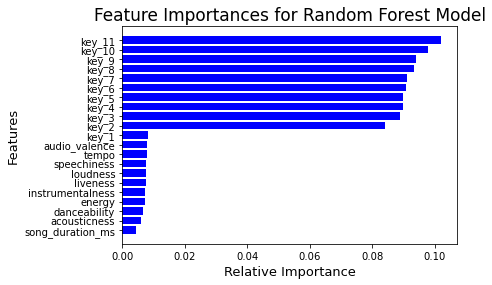

In [59]:
index = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
_ = plt.barh(index, important, align='center',color='b')
_ = plt.xlabel('Relative Importance',fontsize = 13)
_ = plt.ylabel('Features',fontsize = 13)
_ = plt.yticks(index, features)
_ = plt.title('Feature Importances for Random Forest Model',fontsize = 17)
plt.savefig("rfimportance.png")
plt.show()

By the looks of it, the key signature seems to be the most important thing in the model by far. This actually seems logical as some time signatures are popular and more commonly used. That being said, it is still a little dissapointing that the model is so focused on key signature, but thats the way the cookie crumbles. From here, the steps that I can take are maybe trying to do some additional feature engineering (probably with featuretools as I can't think of any normal or logical ways to relate the categories as is), but even then I can't expect much of an increase. That being said, I can now somewhat comfortably make the claim that the features of a song have little impact on the popularity of a song, and what impact they have is probably mostly to do with the key signature of the song.